In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, ZeroPadding2D, \
    Dropout, Conv2DTranspose, Cropping2D, Add, BatchNormalization, Dropout, Activation, Reshape, Permute, Convolution2D
from tensorflow.keras.models import Model

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import visualkeras
import scipy
from PlotKeras import RandomCoordinates, LossSurface
import statsmodels.api as sm
#https://mathformachines.com/posts/visualizing-the-loss-landscape/

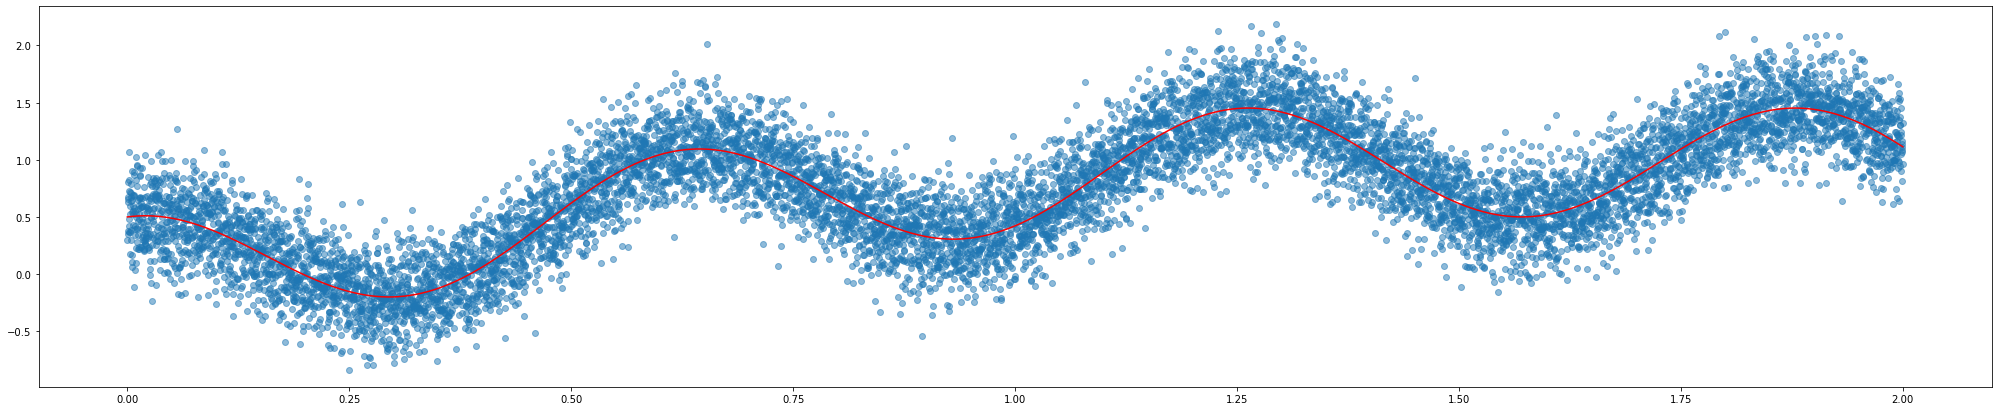

In [5]:
v =  [np.sin(x)+ 0.5*np.cos(10*x)   + np.random.normal(0, 0.25, 1) for x in np.linspace(0,2, 10000)]
gt = [np.sin(x) + 0.5*np.cos(10*x) for x in np.linspace(0, 2, 10000)]

plt.figure(figsize = (35, 7))
plt.scatter(np.linspace(0,2, 10000), v,alpha=0.5)
plt.plot(np.linspace(0,2, 10000), gt, c = 'red')
plt.show()

In [6]:
X = np.stack([np.linspace(0, 2, 10000)]).T.reshape((-1,1))
Y = np.array(v).reshape((-1))
tr = random.sample([*range(10000)], 9000)
te = random.sample([*range(10000)], 1000)

In [7]:
X_train, X_test, y_train, y_test = X[tr], X[te], Y[tr], Y[te]

In [ ]:
inpt = tf.keras.Input(shape=(1,))
d1 = tf.keras.layers.Dense(16,activation='relu', kernel_initializer = 'he_uniform')(inpt)
d2 = tf.keras.layers.Dense(16,activation='relu', kernel_initializer = 'he_uniform')(d1)
d3 = tf.keras.layers.Dense(1, activation='linear', use_bias=True)(d2)

model = Model(inputs = inpt, outputs = d3)
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

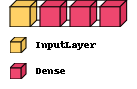

In [9]:
visualkeras.layered_view(model, legend = True)

In [10]:
coords = RandomCoordinates(model.get_weights())
loss_surface = LossSurface(model, X_train, y_train)
N = 25
a_grid,b_grid, loss_grid = loss_surface.compile(points= N, range = 1, coords=coords)

2022-02-21 11:29:50.100053: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10.0


<AxesSubplot:>

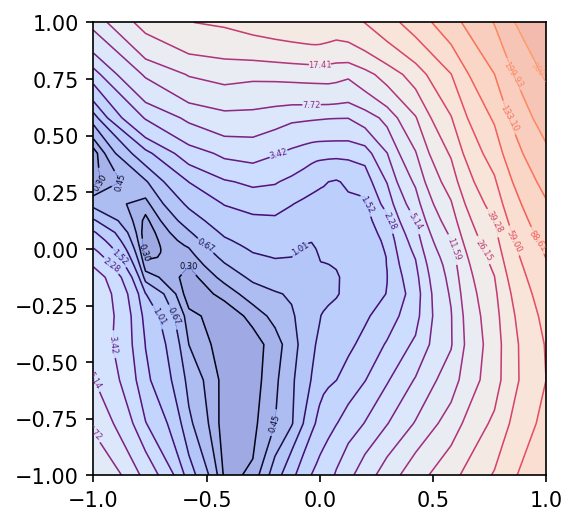

In [11]:
loss_surface.plot(dpi = 150)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
lr_adjust=tf.keras.callbacks.ReduceLROnPlateau( monitor="val_loss", factor=0.5, patience=2, verbose=1, mode="auto",min_delta=0.001,  cooldown=0,  min_lr=1e-3)

history = model.fit(X_train,y_train,
                     steps_per_epoch = 10,
                     batch_size=30,
                     validation_data = (X_test,y_test),
                     validation_steps = 1,
                     epochs = 5000,
                     verbose=0, callbacks=[lr_adjust])

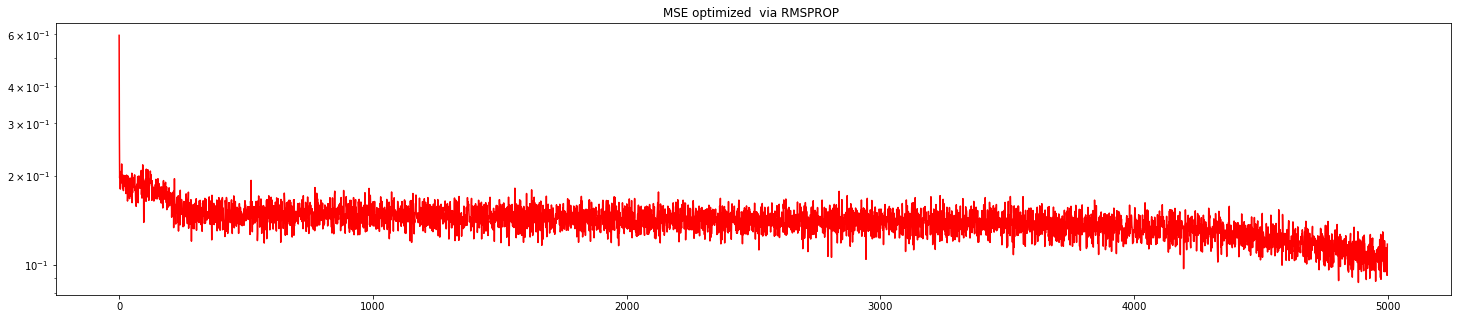

In [14]:
plt.figure(figsize = (25, 5))
plt.plot(history.history['loss'], c = 'red')
plt.yscale('log')
plt.title("MSE optimized  via RMSPROP ")
plt.show()

In [15]:
gtest = [0.5*np.sin(x) + np.cos(2*x)+0.25*np.cos(10*x) for x in np.linspace(0, 2, 1000)]
Test = np.stack([np.linspace(0,  0.6, 1000)]).T.reshape((-1,1))
pred = model.predict(Test)

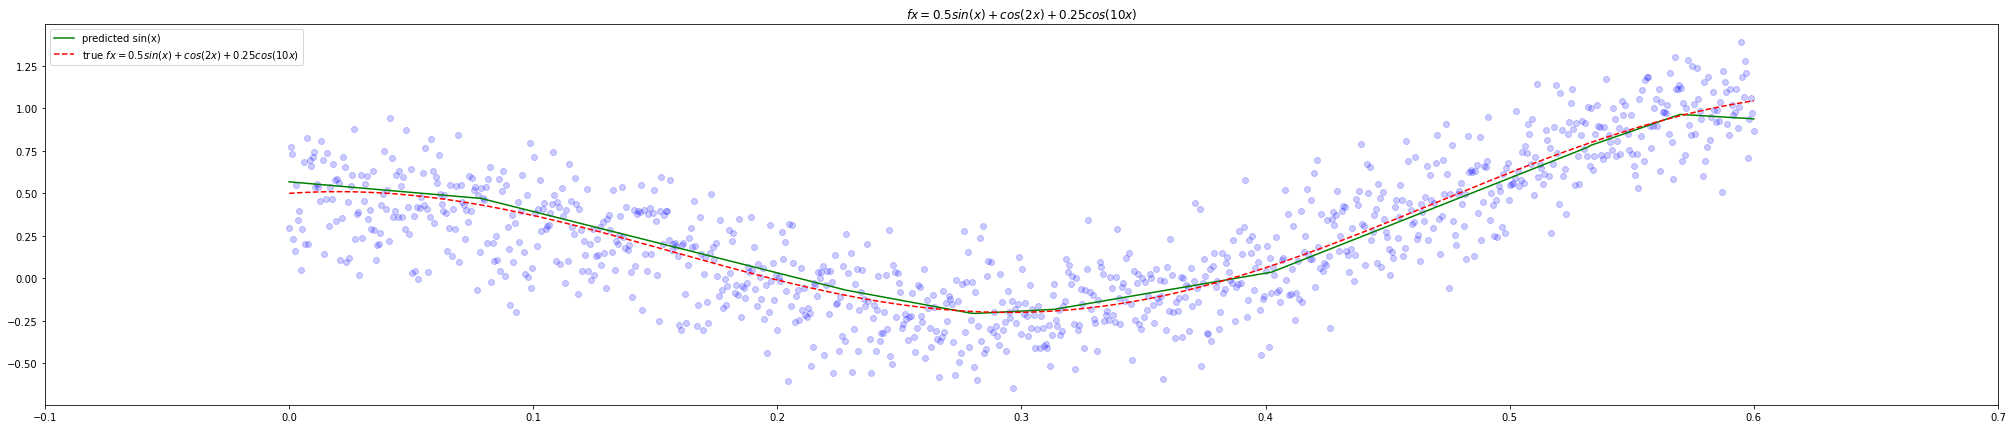

In [24]:
plt.figure(figsize = (35, 7))

v =  [np.sin(x)+ 0.5*np.cos(10*x)   + np.random.normal(0, 0.2, 1) for x in np.linspace(0, 0.6, 1000)]
gt = [np.sin(x) + 0.5*np.cos(10*x) for x in np.linspace(0, 0.6, 1000)]

plt.plot(np.linspace(0, 0.6, 1000), pred, c = 'g', label = 'predicted sin(x)')
plt.plot(np.linspace(0, 0.6, 1000), gt, c = 'red', ls = '--', label ='true $f{x} = 0.5sin(x) + cos(2x) + 0.25cos(10x)$')
plt.scatter(np.linspace(0, 0.6, 1000), v, c = 'b', alpha = 0.2)
plt.legend()
plt.xlim(-0.1, 0.7)
plt.title("$f{x} = 0.5sin(x) + cos(2x) + 0.25cos(10x)$")
plt.show()

In [17]:
print("MSE", round(mean_squared_error(gt,pred), 3))
print("RMSE", round(np.sqrt(mean_squared_error(gt, pred)), 3))
print("R2: ", round(r2_score(gt,pred), 3))

MSE 0.001
RMSE 0.03
R2:  0.993


In [18]:
residuals = (pred - v).reshape((-1))

#### Test normalności reszt

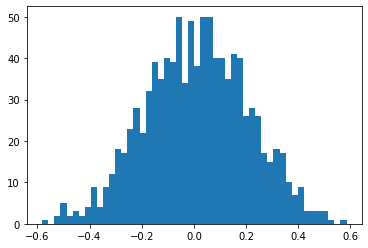

In [19]:
plt.hist(residuals, bins = 50)
plt.show()

Test normalności reszt </br>
$H_{o}: x \sim N(0, \sigma^{2})$ </br>

In [20]:
shapiro_test = scipy.stats.shapiro(residuals).pvalue
if shapiro_test > 0.05:
    print(f"Reszty są w rozkładzie normalnym - nie mamy podstaw do odrzucenia hipotezy zerowej({round(shapiro_test,2)})")

Reszty są w rozkładzie normalnym - nie mamy podstaw do odrzucenia hipotezy zerowej(0.56)


#### Test białoszumowości kwadratów reszt

In [21]:
LB = sm.stats.acorr_ljungbox(residuals**2, lags=[10], return_df = True)

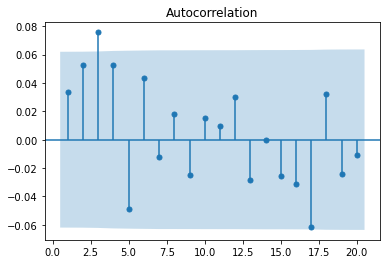

In [22]:
sm.graphics.tsa.plot_acf(residuals**2, lags = 20, zero = False)
plt.show()

In [23]:
if LB['lb_pvalue'].values[0] > 0.05:
    print(f"Nie występuje istotna autokorelacja w kwadratach reszt  - nie mamy podstaw do odrzucenia hipotezy zerowej({LB['lb_pvalue'].values[0].round(3)})")

Nie występuje istotna autokorelacja w kwadratach reszt  - nie mamy podstaw do odrzucenia hipotezy zerowej(0.052)
